In [1]:
import pydpmd as dp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
path = '/home/mmccraw/dev/data/10-18-25/example-homework-data/'
data = dp.data.load(os.path.join(path, 'dynamics'), location=['final', 'init'], load_trajectory=True, load_full=True)

# Problem 1

You are provided with trajectory data from a 2D molecular dynamics simulation in the file $\texttt{trajectories.h5}$.  The units of mass are expressed in terms of the particle mass $m$, the distances are in terms of the particle diameter $\sigma$, and energies are in terms of the interaction energy scale $\varepsilon$.  All other units can be expressed in terms of $m$, $\sigma$, and $\varepsilon$.  There are $N=1000$ particles enclosed in a square region of area $A$ and side length $L\approx39.37 \sigma$.  The total energy in the system is $E=\Sigma_i^N KE_i + \Sigma_i^N PE_i\approx 1.37 \varepsilon$.  The simulation ran for $100K$ steps, with a timestep of $\Delta t=10^{-2} t_0$ where $t_0$ is the unit of time for the simulation.  Every $50^{th}$ step is saved to $\texttt{trajectories.h5}$.

- 1.1 Load the trajectory data, calculate the MSD, and plot it as a function of the lag time.  Include units in terms of the variables $m$, $\sigma$, and $\varepsilon$ (hint: you have to figure out how to express $t_0$ in terms of these units).

  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [00:07<00:00, 265.30it/s] 


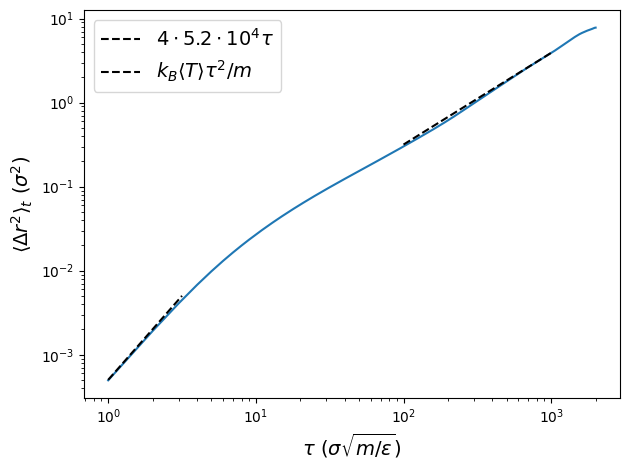

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm

def calc_msd(x, y, t):
    results = np.zeros(len(t) - 1)
    windows = np.zeros_like(results)
    for i in tqdm(range(1, len(t))):
        results[i - 1] = np.sum((x[i:] - x[:-i]) ** 2 + (y[i:] - y[:-i]) ** 2) / (x[i:].size)
        windows[i - 1] = i
    return results, windows

with h5py.File(os.path.join(path, 'dynamics', 'trajectories.h5'), 'r') as f:
    pos = f['pos'][()]
    t = f['timestep'][()].squeeze() * 1e-2
    ke = f['ke_total'][()]

msd, tau = calc_msd(pos[:, :, 0], pos[:, :, 1], t)

plt.plot(tau, msd)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau \ (\sigma \sqrt{m/\varepsilon})$', fontsize=14)
plt.ylabel(r'$\langle \Delta r^2 \rangle_t \ (\sigma^2)$', fontsize=14)
T = (np.mean(data.trajectory.ke_total) / 2000)
mask_long = tau > 5e2
m, b = np.polyfit(np.log10(tau[mask_long]), np.log10(msd[mask_long]), 1)
D = (10 ** b) / 4
x_long = np.logspace(2, 3, 10)
plt.plot(x_long, 4 * D * x_long ** m, linestyle='--', color='k', label=rf'$4 \cdot {D*1e4:.1f} \cdot 10^4 \tau$')
x_short = np.logspace(0, 0.5, 10)
plt.plot(x_short, T * x_short ** 2, linestyle='--', color='k', label=r'$k_B \langle T \rangle \tau^2 / m$')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('figures/problem1-1.png', dpi=300)

- 1.2 Calculate the long time diffusion coefficient $D$ from the MSD data and your fit for $\langle \Delta r^2 \rangle_{long}(\tau)\approx 4 D \tau$ in your plot.  The short time behavior of the MSD is given as $\langle \Delta r^2 \rangle_{short}(\tau)\approx k_B \langle T\rangle \tau^2 / m$ (where $k_B$ is Boltzmann's constant) and $\langle T\rangle=\langle KE \rangle / k_B N$ is the average temperature.  Include $\langle \Delta r^2 \rangle_{short}$ in your plot and explain why there are distinct behaviors for the short and long time trajectories.

In [8]:
# see above

- 1.3  Calculate $g(r)$.

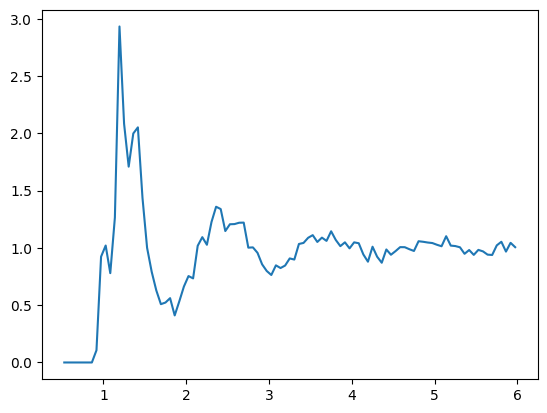

In [41]:
with h5py.File(os.path.join(path, 'dynamics', 'trajectories.h5'), 'r') as f:
    pos = f['pos'][()]
    t = f['timestep'][()].squeeze() * 1e-2
    ke = f['ke_total'][()]
box_size = data.box_size

r_min = 0.5
r_max = 6
n_bins = 100
edges = np.linspace(r_min, r_max, n_bins)
r = 0.5 * (edges[:-1] + edges[1:])
dr = r[1] - r[0]
N = pos[0].shape[0]
counts = np.zeros_like(r)

for i in range(pos.shape[1] - 1):
    d = pos[0][i+1:] - pos[0][i]
    d -= box_size[0] * np.round(d / box_size[0])
    dist = np.linalg.norm(d, axis=-1)
    m = (dist >= edges[0]) & (dist < edges[-1])
    _counts, _ = np.histogram(dist, edges)
    counts += _counts

shell = 2.0 * np.pi * r * dr             # 2D shell length * dr
expected = 0.5 * N * (N - 1) * (shell / np.prod(box_size[0]))
g = counts / expected

plt.plot(r, g)

# Problem 2

In [2]:
def simulate_md_A(pos0, vel0, radii, box_size, n_steps, dt, E):
    """
    Reference 2D Velocity-Verlet with minimum-image PBC (distances only).
    Inputs:
        pos0: (N,2), vel0: (N,2), radii: (N,), box_size: (2,), n_steps: int, dt: float, E: float
    Returns:
        pos_hist: (n_steps, N, 2)
        vel_hist: (n_steps, N, 2)
        force_hist: (n_steps, N, 2)
        KE: (n_steps,)
        PE: (n_steps,)
    """
    N = pos0.shape[0]
    pos = pos0.astype(float).copy()
    vel = vel0.astype(float).copy()
    m = np.ones(N, dtype=float)  # unit masses

    pos_hist = np.zeros((n_steps, N, 2), dtype=float)
    vel_hist = np.zeros((n_steps, N, 2), dtype=float)
    force_hist = np.zeros((n_steps, N, 2), dtype=float)
    KE = np.zeros(n_steps, dtype=float)
    PE = np.zeros(n_steps, dtype=float)

    def minimum_image(vec, box):
        # vec, box are (2,)
        return vec - box * np.round(vec / box)

    def forces_and_energy(pos):
        F = np.zeros_like(pos)
        pe = 0.0
        for i in range(N - 1):
            for j in range(i + 1, N):
                rij = pos[j] - pos[i]
                rij = minimum_image(rij, box_size)
                r = np.hypot(rij[0], rij[1])
                sigma = radii[i] + radii[j]
                overlap = sigma - r
                if overlap > 0.0 and r > 0.0:
                    # Harmonic repulsion in overlap
                    fmag = E * overlap
                    fij = fmag * (rij / r)
                    F[i] -= fij
                    F[j] += fij
                    pe += 0.5 * E * overlap * overlap
        return F, pe

    # Initial forces
    F, pe = forces_and_energy(pos)

    for t in range(n_steps):
        # half-step velocity
        vel += 0.5 * dt * (F / m[:, None])
        # full-step position (no wrapping; PBC only via distances)
        pos += dt * vel
        # new forces
        F_new, pe = forces_and_energy(pos)
        # second half-step velocity
        vel += 0.5 * dt * (F_new / m[:, None])

        # record & roll
        pos_hist[t] = pos
        vel_hist[t] = vel
        force_hist[t] = F_new
        KE[t] = 0.5 * np.sum(m[:, None] * vel * vel)
        PE[t] = pe
        F = F_new

    return pos_hist, vel_hist, force_hist, KE, PE


def simulate_md_B(pos0, vel0, radii, box_size, n_steps, dt, E):
    """
    Buggy variant that still runs. Students should identify issues by checking
    momentum/energy behavior and PBC handling.
    Same inputs/outputs as simulate_md_A.
    """
    N = pos0.shape[0]
    pos = pos0.astype(float).copy()
    vel = vel0.astype(float).copy()
    m = np.ones(N, dtype=float)

    pos_hist = np.zeros((n_steps, N, 2), dtype=float)
    vel_hist = np.zeros((n_steps, N, 2), dtype=float)
    force_hist = np.zeros((n_steps, N, 2), dtype=float)
    KE = np.zeros(n_steps, dtype=float)
    PE = np.zeros(n_steps, dtype=float)

    def broken_minimum_image(vec, box):
        # BUG 1: asymmetric “wrap into [0,L)” rather than centered minimum image;
        # also applies wrap only in x, not y (common oversight).
        v = vec.copy()
        v[0] = np.mod(v[0], box[0])
        return v

    def forces_and_energy_broken(pos):
        F = np.zeros_like(pos)
        pe = 0.0
        for i in range(N):
            # BUG 2: loop j over all j != i (fine) but apply forces ONLY to i (one-sided),
            # violating Newton's third law -> spurious COM acceleration.
            for j in range(N):
                if j == i:
                    continue
                rij = pos[j] - pos[i]
                rij = broken_minimum_image(rij, box_size)  # wrong PBC
                r = np.hypot(rij[0], rij[1])
                sigma = radii[i] + radii[j]
                overlap = sigma - r
                if overlap > 0.0 and r > 0.0:
                    fmag = E * overlap
                    fij = fmag * (rij / r)
                    F[i] -= fij      # BUG 2 continued: missing F[j] += fij
                    # BUG 3: double counts PE by summing i->j and j->i contributions
                    pe += 0.5 * E * overlap * overlap
        return F, pe

    # Initial forces (buggy)
    F, pe = forces_and_energy_broken(pos)

    for t in range(n_steps):
        # BUG 4: uses only a single full-step velocity update with OLD forces
        # (semi-implicit Euler-ish), skipping the second half-kick -> poor energy behavior.
        vel += dt * (F / m[:, None])
        pos += dt * vel  # positions still not wrapped; PBC only via distances (as requested)

        F_new, pe = forces_and_energy_broken(pos)
        # (Missing second half-kick intentionally)

        pos_hist[t] = pos
        vel_hist[t] = vel
        force_hist[t] = F_new
        KE[t] = 0.5 * np.sum(m[:, None] * vel * vel)
        PE[t] = pe
        F = F_new

    return pos_hist, vel_hist, force_hist, KE, PE

In [ ]:
data = dp.data.load('/home/mmccraw/dev/data/10-18-25/example-homework-data-small/dynamics', location='final')
pos = data.pos.copy()
vel = data.vel.copy()
rad = data.rad.copy()
box_size = data.box_size[0].copy()
np.savez('problem2.npz', pos=pos, vel=vel, rad=rad, box_size=box_size)


results_A = simulate_md_A(pos, vel, rad, box_size, 1000, 1e-2, 1)
results_A = {n: r for n, r in zip(['pos', 'vel', 'force', 'ke', 'pe'], results_A)}


results_B = simulate_md_B(pos, vel, rad, box_size, 1000, 1e-2, 1)
results_B = {n: r for n, r in zip(['pos', 'vel', 'force', 'ke', 'pe'], results_B)}

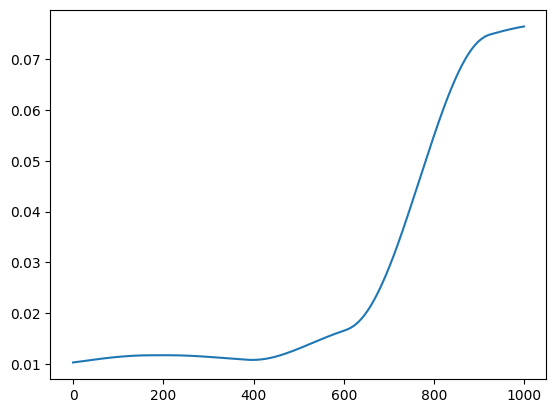

In [4]:
plt.plot(results_B['pe'] + results_B['ke'])